In [1]:
import csv
import time
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
import sklearn
import sklearn.tree
import sklearn.ensemble
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler 
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression



In [4]:
def normalize(x):
    '''This function nomalizes each columns of the input 2d array.'''
    x_mean = np.mean(x, axis=0)
    x_std = np.std(x, axis=0)
    x_std[x_std == 0] = 1
    x1 = (x - x_mean) / x_std
    return x1


def addFeature (X_train, X_test1, X_test2, add_feature):
    addFeatureLen = len(add_feature)
    for i1 in range (addFeatureLen):
        for i2 in range (i1,addFeatureLen, 1):
            newFeature1 = np.array(X_train[:,i1]*X_train[:,i2]).reshape(-1,1)
            #print (np.shape(newFeature1))
            X_train = np.hstack((X_train, newFeature1))
            newFeature2 = np.array(X_test1[:,i1]*X_test1[:,i2]).reshape(-1,1)
            X_test1 = np.hstack((X_test1, newFeature2))
            newFeature3 = np.array(X_test2[:,i1]*X_test2[:,i2]).reshape(-1,1)
            X_test2 = np.hstack((X_test2, newFeature3))
    return (X_train, X_test1, X_test2)

#select features using lasso
def selectFeature(X_train, y_train, X_test1, X_test2, alpha1):
    '''This function select the features of normalized data (i.e., np.std(X[:,j]) = 1 or 0).
    Firstly Lasso regression will used to fit the data 'X_train, y_train', the column X[:,j]
    will be selected if wj > 0.'''
    lasso = linear_model.Lasso(alpha=alpha1)
    lasso.fit(X_train, y_train)
    cols = (abs(lasso.coef_) > 0)
    x_train = X_train[:, cols]
    x_test1 = X_test1[:, cols]
    x_test2 = X_test2[:, cols]
    str1 = 'The regularization alpha in the Lasso regression is %.6f ; '
    str2 = ' %d features have been selected.'
    print(str1 % alpha1, str2 % sum(cols))
    return (x_train, x_test1, x_test2)

# load the the data from the files
with open('train_2008.csv', 'r') as file1: 
    lines1 = csv.reader(file1, delimiter=',', quotechar='|') 
    next(lines1, None)
    data1 = np.array([line for line in lines1], dtype=float)

with open('test_2008.csv', 'r') as file2:
	lines2 = csv.reader(file2, delimiter=',', quotechar='"')
	next(lines2, None)
	data2 = np.array([line for line in lines2], dtype=float)

with open('test_2012.csv', 'r') as file3:
	lines3 = csv.reader(file3, delimiter=',', quotechar='"')
	next(lines3, None)
	data3 = np.array([line for line in lines3], dtype=float)


# convert the data to float numpy array 
alpha1 = 0.0075
#add_feature = [6,7,39,41,48,57,64,371,374];
#add_feature = [8, 17, 26, 30, 31, 43, 92, 135]
N_train = len(data1)
y_train = 2 * (data1[:, -1] - 1.5)  # maps 1 to -1, 2 to 1
X_train = normalize(data1[:, :-1])
X_train[:, 0] = 1
X_test1 = normalize(data2)
X_test1[:, 0] = 1
X_test2 = normalize(data3)
X_test2[:, 0] = 1
#qmin, qmax = 1, 100
#X_train, X_test1, X_test2 = addFeature(X_train, X_test1, X_test2, add_feature)
#X_train, X_test1, X_test2 = selectFeature(X_train, y_train, X_test1, X_test2, alpha1) 

d = len(X_train[0])
print (d)





382


In [3]:

# train the model and calculate the scores by cross-validation
N = 200
clf1 = AdaBoostClassifier(n_estimators=N)
clf2 = GradientBoostingClassifier(loss='deviance', learning_rate=0.05, 
                                  n_estimators=180, subsample=0.8, 
                                  criterion='friedman_mse', min_samples_split=10, 
                                  min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                  max_depth=3, min_impurity_split=1e-07, init=None, 
                                  random_state=None, max_features=None, verbose=0, 
                                  max_leaf_nodes=None, warm_start=False, presort='auto')
clf3 = RandomForestClassifier(n_estimators=N, min_samples_split=2, max_depth=10, oob_score=True)
clf4 = xgb.XGBClassifier(max_depth=4, silent = 1, objective = 'binary:logistic')
eclf = VotingClassifier(estimators=[('gb', clf2), ('xgb', clf4)], voting='hard')
clf_lst = [clf2,clf4,eclf]
name_lst = ['GradientBoost', 'XGBoost', 'voting']
"""for clf, name in zip(clf_lst, name_lst):
    scores = cross_val_score(clf, X_train, y_train, cv=2, scoring='accuracy')
    print("Accuracy: %0.6f (+/- %0.6f) [%s]" % (scores.mean(), scores.std(), name))"""




'for clf, name in zip(clf_lst, name_lst):\n    scores = cross_val_score(clf, X_train, y_train, cv=2, scoring=\'accuracy\')\n    print("Accuracy: %0.6f (+/- %0.6f) [%s]" % (scores.mean(), scores.std(), name))'

In [5]:
clf4.fit(X_train, y_train)



XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=1, subsample=1)

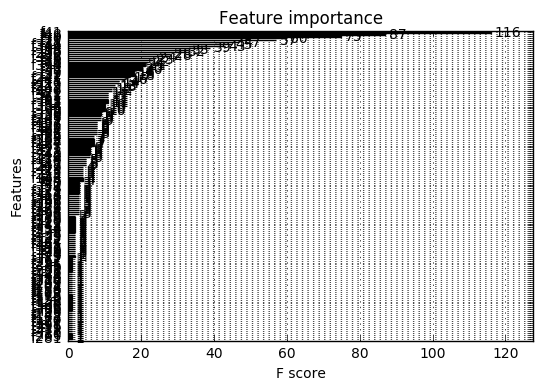

In [6]:
xgb.plot_importance(clf4)
plt.show()

In [33]:
clf4_topfeatureindex = np.argsort(clf4.feature_importances_)[-10:]
clf4_topfeatureindex

array([ 15,  64, 349, 333,  31,  11,  30,  49,  48,  41])

In [19]:

with open('train_2008.csv', 'rt') as file1: 
    lines1 = csv.reader(file1) 
    features_name = lines1.__next__()

In [38]:
np.array(features_name)[clf4_topfeatureindex]

array(['HWHHWGT', 'PRINUSYR', 'PEIO1OCD', 'QSTNUM', 'GESTFIPS', 'HUFAMINC',
       'GESTCEN', 'PTDTRACE', 'PEEDUCA', 'PEAGE'], 
      dtype='<U8')

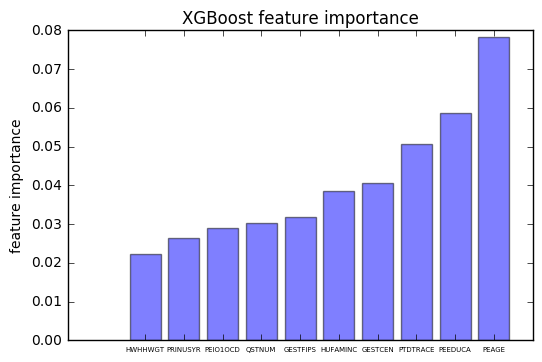

In [46]:
objects = np.array(features_name)[clf4_topfeatureindex]
y_pos = np.arange(len(objects))
feature_importance = clf4.feature_importances_[clf4_topfeatureindex]
 
plt.bar(y_pos, feature_importance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, fontsize = 5)
plt.ylabel('feature importance')
plt.title('XGBoost feature importance')
plt.savefig('XGBoostfeature_importance.png')
plt.show()

In [47]:
clf1.fit(X_train, y_train)



AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=200, random_state=None)

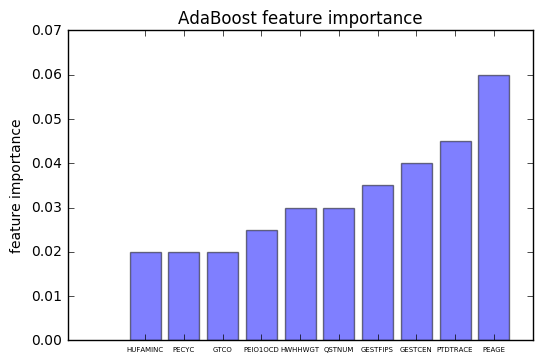

0

In [48]:
def feature_importance_plot(learned_clf, nameofclassifier, nameofpng):
    topfeatureindex = np.argsort(learned_clf.feature_importances_)[-10:]
    objects = np.array(features_name)[topfeatureindex]
    y_pos = np.arange(len(objects))
    feature_importance = learned_clf.feature_importances_[topfeatureindex]

    plt.bar(y_pos, feature_importance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects, fontsize = 5)
    plt.ylabel('feature importance')
    plt.title(nameofclassifier+' feature importance')
    plt.savefig(nameofpng)
    plt.show()
    return 0

feature_importance_plot(clf1, 'AdaBoost', 'Adaboost_feature_importance.png')

In [49]:
clf2.fit(X_train, y_train)
clf3.fit(X_train, y_train)
eclf.fit(X_train, y_train)

VotingClassifier(estimators=[('gb', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=10, min...ry:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=1, subsample=1))],
         n_jobs=1, voting='hard', weights=None)

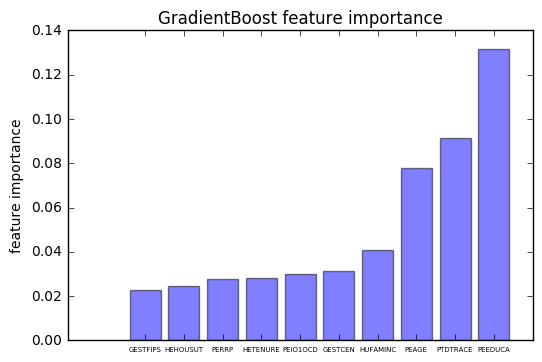

0

In [50]:
feature_importance_plot(clf2, 'GradientBoost', 'GradientBoost_feature_importance.png')

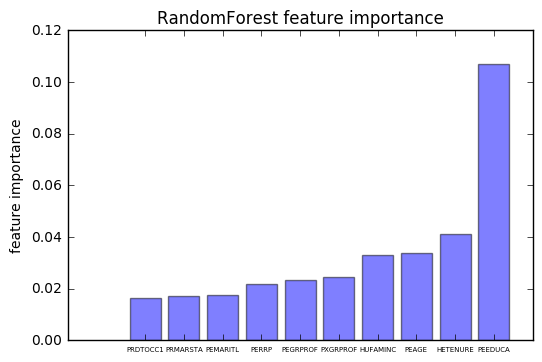

0

In [51]:
feature_importance_plot(clf3, 'RandomForest', 'RandomForest_feature_importance.png')

In [53]:
featureselection_lasso = linear_model.Lasso(alpha=alpha1)
featureselection_lasso.fit(X_train, y_train)

Lasso(alpha=0.0075, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

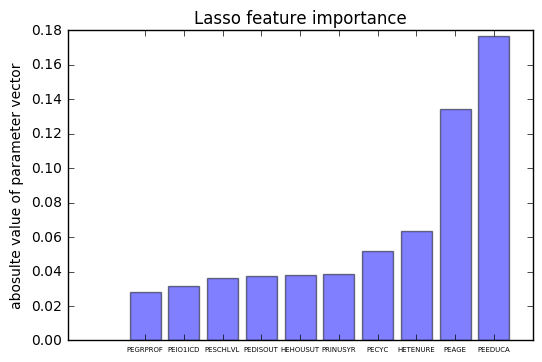

SyntaxError: 'return' outside function (<ipython-input-67-587a8fcbf86a>, line 13)

In [67]:

lasso_topfeatureindex = np.argsort(np.abs(featureselection_lasso.coef_))[-10:]
lasso_objects = np.array(features_name)[lasso_topfeatureindex]
lasso_y_pos = np.arange(len(objects))
lasso_feature_importance = np.abs(featureselection_lasso.coef_)[lasso_topfeatureindex]

plt.bar(lasso_y_pos, lasso_feature_importance, align='center', alpha=0.5)
plt.xticks(lasso_y_pos, lasso_objects, fontsize = 5)
plt.ylabel('abosulte value of parameter vector')
plt.title('Lasso feature importance')
plt.savefig('lasso_featureimportance.png')
plt.show()
return 0

In [64]:
from functools import reduce
common_important_features = reduce(np.intersect1d, (np.argsort(np.abs(featureselection_lasso.coef_))[-20:],
                        np.argsort(clf1.feature_importances_)[-20:], 
                        np.argsort(clf2.feature_importances_)[-20:],
                       np.argsort(clf3.feature_importances_)[-20:],
                       np.argsort(clf4.feature_importances_)[-20:],))


In [66]:
np.array(features_name)[common_important_features]

array(['HUFAMINC', 'PEAGE', 'PEEDUCA', 'PEIO1OCD'], 
      dtype='<U8')

In [68]:
DTcommon_important_features = reduce(np.intersect1d, (np.argsort(clf1.feature_importances_)[-20:], 
                        np.argsort(clf2.feature_importances_)[-20:],
                       np.argsort(clf3.feature_importances_)[-20:],
                       np.argsort(clf4.feature_importances_)[-20:],))
np.array(features_name)[DTcommon_important_features]

array(['HUFAMINC', 'PEAGE', 'PEEDUCA', 'PEIO1OCD'], 
      dtype='<U8')